In [107]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras import layers

In [2]:
extended_df = pd.read_csv('extended_train.csv')

In [5]:
extended_df['total_frames'].min()

2

In [15]:
extended_df['total_frames'].value_counts().to_dict()

{6: 11744,
 15: 2604,
 16: 2553,
 12: 2504,
 13: 2504,
 17: 2438,
 14: 2410,
 11: 2371,
 18: 2342,
 20: 2243,
 10: 2195,
 19: 2189,
 21: 2050,
 9: 1964,
 22: 1885,
 23: 1860,
 8: 1846,
 24: 1796,
 7: 1726,
 25: 1576,
 26: 1465,
 28: 1437,
 27: 1374,
 29: 1250,
 30: 1233,
 32: 1148,
 31: 1120,
 33: 1018,
 34: 880,
 36: 860,
 40: 820,
 35: 814,
 44: 756,
 37: 747,
 39: 707,
 48: 692,
 38: 670,
 45: 658,
 43: 656,
 41: 637,
 52: 628,
 42: 618,
 47: 589,
 56: 558,
 51: 518,
 46: 510,
 53: 473,
 50: 449,
 49: 447,
 55: 442,
 60: 430,
 54: 423,
 64: 400,
 57: 350,
 68: 336,
 72: 305,
 61: 278,
 76: 278,
 84: 277,
 59: 277,
 58: 267,
 80: 266,
 92: 250,
 88: 232,
 65: 225,
 63: 217,
 100: 214,
 67: 209,
 96: 208,
 62: 179,
 69: 178,
 104: 173,
 75: 169,
 108: 169,
 71: 163,
 66: 155,
 73: 155,
 81: 155,
 112: 154,
 97: 154,
 77: 154,
 79: 153,
 85: 153,
 116: 149,
 120: 148,
 93: 145,
 89: 143,
 132: 140,
 124: 136,
 83: 131,
 128: 130,
 70: 129,
 101: 118,
 113: 114,
 87: 113,
 86: 112,
 74:

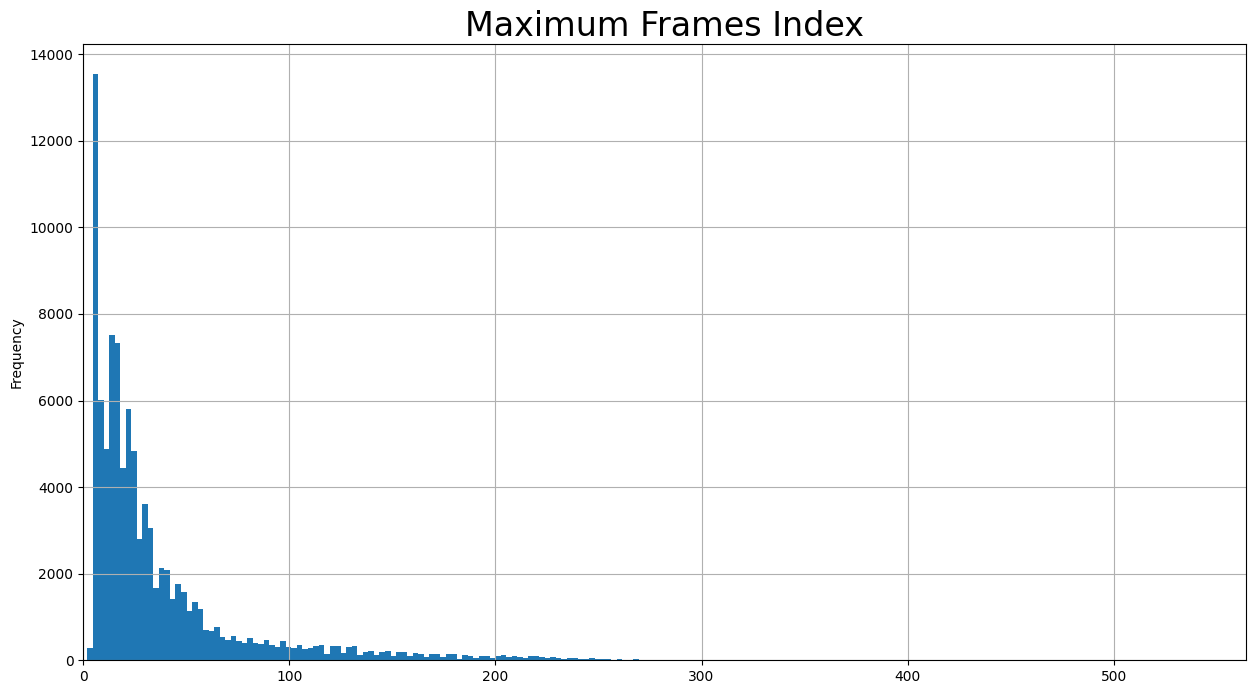

In [27]:

plt.figure(figsize=(15,8))
plt.title('Maximum Frames Index', size=24)
extended_df['total_frames'].plot(kind='hist', bins=200)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.layers import MultiHeadAttention, Add, LayerNormalization
from tensorflow.keras.models import Model

class TransformerDecoder(tf.keras.Model):
    def __init__(self, d_model, num_heads, dff, target_vocab_size, dropout_rate=0.1):
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.target_vocab_size = target_vocab_size
        self.dropout_rate = dropout_rate
    
    def create_model(self, max_seq_length):
        # Input layer
        decoder_input = Input(shape=(max_seq_length, 61, 2), name='decoder_input')
        # Positional Encoding layer
        pos_enc = self._positional_encoding(max_seq_length, self.d_model)(decoder_input)
        # Dropout layer
        dropout_1 = Dropout(self.dropout_rate)(pos_enc)
        
        # Decoder layers
        for i in range(3):
            # Multi-Head Attention layer
            attn_output = self._multihead_attention(q=dropout_1, k=dropout_1, v=dropout_1)
            # Add and Layer Normalization
            add_norm_1 = self._add_and_norm(dropout_1, attn_output)
            # Feedforward layer
            ff_output = self._feed_forward(add_norm_1)
            # Add and Layer Normalization
            dropout_2 = Dropout(self.dropout_rate)(ff_output)
            add_norm_2 = self._add_and_norm(add_norm_1, dropout_2)
        
        # Output layer
        decoder_output = Dense(self.target_vocab_size, activation='softmax', name='decoder_output')(add_norm_2)
        
        # Model
        model = Model(inputs=decoder_input, outputs=decoder_output, name='transformer_decoder')
        return model
        
    def _positional_encoding(self, max_seq_length, d_model):
        # Positional Encoding layer
        pos = np.arange(max_seq_length)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        sin = np.sin(angle_rads[:, 0::2])
        cos = np.cos(angle_rads[:, 1::2])
        pos_encoding = np.concatenate([sin, cos], axis=-1)
        pos_encoding = pos_encoding[np.newaxis, ...]
        return pos_encoding
    
    def _multihead_attention(self, q, k, v):
        # Multi-Head Attention layer
        mha = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.d_model)
        attn_output = mha(query=q, key=k, value=v)
        return attn_output
    
    def _feed_forward(self, x):
        # Feedforward layer
        ff = Dense(units=self.dff, activation='relu')
        ff_output = ff(x)
        ff_output = Dense(units=self.d_model)(ff_output)
        return ff_output
    
    def _add_and_norm(self, x1, x2):
        # Add and Layer Normalization
        add = Add()([x1, x2])
        layer_norm = LayerNormalization(epsilon=1e-6)(add)
        return layer_norm


In [37]:
model = TransformerDecoder(d_model=256, num_heads=4, dff=512, target_vocab_size=250, dropout_rate=0.1)

In [39]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [123]:
LIP = [
            61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
            291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
            78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
            95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]


In [135]:
video_df = pd.read_parquet('train_landmark_files/16069/100015657.parquet', engine='pyarrow')
video_df.fillna(-999,inplace=True)
left_df = video_df[video_df.type=='left_hand']
left_values = left_df[['x','y','z']].values
left_values = left_values.reshape(-1,21,3)
right_df = video_df[video_df.type=='right_hand']
right_values = right_df[['x','y','z']].values
right_values = right_values.reshape(-1,21,3)
right_df = video_df[video_df.type=='right_hand']
right_values = right_df[['x','y','z']].values
right_values = right_values.reshape(-1,21,3)

face_df = video_df[video_df.type=='face']
face_df = face_df[['x','y','z']].values
face_df = face_df.reshape(-1,468,3)
lip_values = face_df[:,LIP,:]

In [141]:
left_values.shape

(105, 21, 3)

In [147]:
np.where(right_values[9]==-999)

(array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,
         5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,
        11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16,
        17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20]),
 array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
        1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1,
        2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]))

In [126]:
len(video_df[video_df.type=='face'])

49140

In [131]:
49140/video_df.frame.nunique()

468.0

In [122]:
video_df[video_df['type']=='right_hand']

,frame,row_id,type,landmark_index,x,y,z
522,103,103-right_hand-0,right_hand,0,-1.0,-1.0,-1.0
523,103,103-right_hand-1,right_hand,1,-1.0,-1.0,-1.0
524,103,103-right_hand-2,right_hand,2,-1.0,-1.0,-1.0
525,103,103-right_hand-3,right_hand,3,-1.0,-1.0,-1.0
526,103,103-right_hand-4,right_hand,4,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...
57010,207,207-right_hand-16,right_hand,16,-1.0,-1.0,-1.0
57011,207,207-right_hand-17,right_hand,17,-1.0,-1.0,-1.0
57012,207,207-right_hand-18,right_hand,18,-1.0,-1.0,-1.0
57013,207,207-right_hand-19,right_hand,19,-1.0,-1.0,-1.0


In [114]:
input_shape = (300,61,2)
num_classes = 250
embed_dim = 122
num_heads = 4
layer_norm_eps = 1e-6
transformer_layers = 2

def get_transformer(
    input_shape,
    num_classes,
    embed_dim,
    num_heads,
    layer_norm_eps,
    transformer_layers
):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.layers.Reshape(target_shape=(300,61*2))(inputs)
    encoded_patches  = x + positional_encoding(300,61*2)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
    # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1,attention_mask=)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = tf.keras.Sequential(
          [
              layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
              layers.Dense(units=embed_dim, activation=tf.nn.gelu),
          ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)
    representation = layers.Dense(512, activation = tf.nn.gelu)(representation)
    representation = layers.Dense(256, activation = tf.nn.gelu)(representation)
    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [115]:
model = get_transformer(input_shape,
    num_classes,
    embed_dim,
    num_heads,
    layer_norm_eps,
    transformer_layers)

In [116]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300, 61, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 reshape_12 (Reshape)           (None, 300, 122)     0           ['input_7[0][0]']                
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 300, 122)    0           ['reshape_12[0][0]']             
 ambda)                                                                                           
                                                                                              

In [98]:
import tensorflow as tf

# create the mask tensor with shape (batch_size, sequence_length)
mask = tf.constant([[1.0,1.0,0.0,0.0,0.0]], dtype=tf.float32)
mask = tf.repeat(mask,repeats=2,axis=0)
print(mask)
mask = tf.repeat(tf.expand_dims(mask,axis=1),repeats=5,axis=1)
print(mask)


tf.Tensor(
[[1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0.]], shape=(2, 5), dtype=float32)
tf.Tensor(
[[[1. 1. 0. 0. 0.]
  [1. 1. 0. 0. 0.]
  [1. 1. 0. 0. 0.]
  [1. 1. 0. 0. 0.]
  [1. 1. 0. 0. 0.]]

 [[1. 1. 0. 0. 0.]
  [1. 1. 0. 0. 0.]
  [1. 1. 0. 0. 0.]
  [1. 1. 0. 0. 0.]
  [1. 1. 0. 0. 0.]]], shape=(2, 5, 5), dtype=float32)
